In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('lesson_3_data__1_.csv', encoding='windows-1251')
df.head()

,Unnamed: 0,tk,pl,dia,hs,tc,cta,id_art,id_subsubfam,id_subfam,...,id_famn,id_seccion,id_subagr,id_agr,vta,uni,id_artn,art_sp,fam_sp,fam_en
0,1242,120071109002055793,1,2007/11/09,0.505729,110000761,11000076,21895,101070640100,1010706401,...,10107064,10107,101,1,0.68,1.0,21895,MARAVILLA 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta
1,1243,120070601004053633,1,2007/06/01,0.588519,110000761,11000076,21816,101070640100,1010706401,...,10107064,10107,101,1,0.38,1.0,21816,FIDEO CABELLIN 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta
2,1244,120070928004076410,1,2007/09/28,0.785498,28491841,2849184,562840,101070640100,1010706401,...,10107064,10107,101,1,1.55,2.0,562840,SPAGUETTI Nє 5 500 G Brand_1,PASTA ALIMENTICIA SE,pasta
3,1245,120070616003074261,1,2007/06/16,0.550961,95931501,9593150,28914,101070640100,1010706401,...,10107064,10107,101,1,1.03,2.0,28914,FIDEO FIDEUБ 500 Brand_7,PASTA ALIMENTICIA SE,pasta
4,1246,120070519001018477,1,2007/05/19,0.804954,93265591,9326559,159867,101070640100,1010706401,...,10107064,10107,101,1,1.09,1.0,159867,MACARRONES GRATINAR 5 Brand_2,PASTA ALIMENTICIA SE,pasta


In [3]:
# Отберем колонки с идентификатором пользователей и информацией о покупке
# и выделим бренд

user_df = df[['tc', 'art_sp']]
user_df = user_df.rename(columns={'tc': 'user_id', 'art_sp': 'brand_info'})
user_df['brand_name'] = user_df.brand_info.apply(lambda x: x.split()[-1])
user_df.head()

,user_id,brand_info,brand_name
0,110000761,MARAVILLA 500 G Store_Brand,Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand,Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1,Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7,Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2,Brand_2


In [4]:
# Найдем количество покупок для каждого пользователя

purchases_per_user = user_df.groupby('user_id') \
    .agg(purchases=('brand_name', 'size')) \
    .reset_index()

purchases_per_user.head()

,user_id,purchases
0,-1236394515,1
1,1031,6
2,4241,5
3,17311,2
4,17312,2


In [5]:
# Посмотрим на описательные статистики

purchases_per_user.purchases.describe()

count    11764.000000
mean         4.091210
std          4.573143
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         60.000000
Name: purchases, dtype: float64

In [6]:
# Произведем отбор пользователей для дальнейшего анализа.
# С предыдущего шага мы узнали, что 75% пользователей совершило меньше 5 покупок.
# Возьмем тех пользователей, которые совершили от 5 покупок,
# считая это кол-во достаточным для определения уровня лояльности

data = user_df[user_df.user_id.isin(purchases_per_user.query('purchases >= 5').user_id)]
data.head()

,user_id,brand_info,brand_name
0,110000761,MARAVILLA 500 G Store_Brand,Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand,Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1,Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7,Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2,Brand_2


In [7]:
# Посчитаем для каждого пользователя количество покупок каждого бренда

purchases_by_brand = pd.pivot_table(data, index='user_id', 
                                    columns='brand_name',  
                                    aggfunc='size', 
                                    fill_value=0)

purchases_by_brand.head()

brand_name,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5,Brand_7,Store_Brand
user_id,,,,,,,
1031,0,0,1,0,0,0,5
4241,0,0,0,3,0,0,2
25971,0,0,0,2,0,0,5
40911,1,2,3,19,0,0,2
45181,0,1,1,1,0,0,2


In [8]:
# Расчет метрики

def get_metric(row):
    '''
    Если считать лояльность к бренду, учитывая только кол-во покупок,
    то предпочтение будет отдано тем людям, которые больше покупали.
    
    Если считать лояльность к бренду как вероятность того, что человек
    приобретет данный бренд, то предпочтение будет отдаваться тем людям,
    которые меньше покупали у конкурентов.
    
    Мы же будем для каждого пользователя считать вероятность того, 
    что он купит данный бренд, и домножать ее на кол-во покупок данного бренда.
    Так мы учтем оба подхода, описанные выше. То есть, чем больше данная
    вероятность и чем больше кол-вл покупок, совершенное пользователем,
    тем более лояльным он считается.
    '''
    return row * row / row.sum()

def loyalty_score(col):
    '''
    Используем данную функцию, для отображения метрики на отрезок [0, 1].
    Данная функция хорошо подходит, так как она монотонно возрастает на
    всей области определения и стремится к 1 при стремлении 
    аргумента к бесконечности.
    '''
    return 1 - np.exp(-col)

new_col_names = [col + '_loyalty_score' for col in purchases_by_brand.columns]
old_new_col = dict(zip(purchases_by_brand.columns, new_col_names))

users_loyalty = purchases_by_brand.apply(get_metric, axis=1) \
    .apply(loyalty_score) \
    .round(2) \
    .rename(columns=old_new_col)

users_loyalty.head()

brand_name,Brand_1_loyalty_score,Brand_2_loyalty_score,Brand_3_loyalty_score,Brand_4_loyalty_score,Brand_5_loyalty_score,Brand_7_loyalty_score,Store_Brand_loyalty_score
user_id,,,,,,,
1031,0.00,0.00,0.15,0.00,0.0,0.0,0.98
4241,0.00,0.00,0.00,0.83,0.0,0.0,0.55
25971,0.00,0.00,0.00,0.44,0.0,0.0,0.97
40911,0.04,0.14,0.28,1.00,0.0,0.0,0.14
45181,0.00,0.18,0.18,0.18,0.0,0.0,0.55


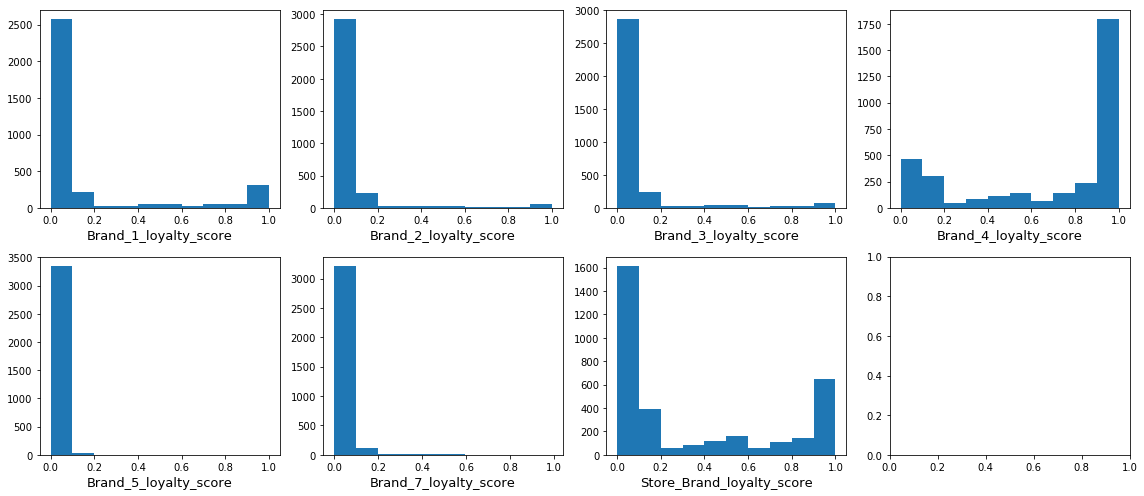

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 7))
for i, col_name in enumerate(users_loyalty.columns):
    axes[i // 4, i % 4].hist(users_loyalty[col_name])
    axes[i // 4, i % 4].set_xlabel(col_name, fontsize=13)
    plt.tight_layout()